# Utility algorithms:

### Recognize evolutions of the same clusers

**Metod:** Cosine simmilarity matrix, cluster alignment using local threshold

**Parameters:**
* Position
* Point count / avg
* Blair-Bliss (density) 
* Correlation coeffitience (roundness) 
* Linear trend direction 


# Phase 1: Outlier/novelty detection on sensors

### For whole map generate scores for each step's:

1) Novelty: In comparison to previous measurements from same calibration 

**Metod:**
    Streaming RRCF

**Parameters:**
* New points count / avg
* Lost points count / avg
* Number of new clusters / avg (Use cluster recognition algorithm)
* Number of lost clusters / avg
* New points in clusters count / avg
* Lost points in clusters count / avg

2) Outlierness : In comparison to other sensors / previous calibrations data

**Metod:** Batch RRCF

**Parameters:**
* Directional density imbalance (Steepness of maximum imbalance axis)
* Local density imbalance (Standard deviation of KNN distance sum)
* Total points count / total
* Number of clusters / avg
* Points in clusters / avg

# Phase 2: Sensor noise progression forecasting


### For each sensor forecast a set of measurements:

**Metod:** Holt-Winters

**Parameters:**
* Directional density imbalance (Steepness of maximum imbalance axis)
* Local density imbalance (Standard deviation of KNN distance sum)
* Total points count
* Number of clusters
* Points in clusters



In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
import rrcf
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression

# Phase 0


### Simulated data generation

In [17]:
index = 0
lines = []
blobs = []

D_MIN = 10

def make_line(h, w, line_len):
    alpha = np.random.uniform(0, np.pi)
    fun = np.poly1d([np.tan(alpha),np.random.randint(0, h)])
    start_X = np.random.randint(0, w)
    # X = np.uniform(start_X, start_X + line_len*np.cos(alpha), size=line_len)
    X = np.linspace(start_X, start_X + line_len*np.cos(alpha), num=line_len)
    Y = fun(X)
    return np.vstack((X%w, Y%h)).T.astype(int)


def make_blob(n_samples, avg_std = 5, size=256):
    return make_blobs(n_samples,
                      cluster_std=np.abs(np.random.randn()*5+1), 
                      centers=1, 
                      center_box=(0,size*0.7))[0].astype(int)

In [18]:
def dice_roll():
    return np.random.rand()


def randmap_generator(gaussian_blob_prob, line_prob, n=100, starting_map=np.zeros((256,256)), amplifying_factor=300):
    randmap = starting_map
    while n > 0:
        yield randmap
        
        if dice_roll() < gaussian_blob_prob:
            for x, y in make_blob(n_samples=np.abs(np.random.randint(40)),size=256):
                randmap[x, y] = amplifying_factor
            blobs.append(index)
        elif dice_roll() < line_prob:
            for x, y in make_line(256, 256, np.abs(np.random.randint(40))):
                randmap[x, y] = amplifying_factor
            lines.append(index)
        else:
            randmap = np.maximum(randmap, np.random.binomial(n=1, p=0.0006,size=(256,256))*amplifying_factor)
        randmap *= np.random.binomial(n=1, p=0.8,size=(256,256))
        n -= 1
        
    

### Utility algorithms

In [19]:
def get_clusters(map_matrix, clustering_algorithm):
    map_points = np.array(
                    list(
                        zip(np.where(map_matrix != 0)[0],
                            np.where(map_matrix != 0)[1])
                    ))
    
    if len(map_points) == 0:
        return []
    
    clustering_algorithm.fit(map_points)
    clustered_points = np.hstack((
                                dbscan.labels_.reshape(-1,1),
                                map_points
                                ))
    return clustered_points

In [20]:
def measure_clusters(clustered_points):
    clusters=[]
    cluster_centroids=[]
    for cluster_number in np.sort(
                            np.unique(
                                clustered_points[:, 0]
                            )):
        if cluster_number != -1:
            
            points_of_cluster = clustered_points[np.where(clustered_points[:,0] == cluster_number), 1:] 
            points_of_cluster = np.squeeze(points_of_cluster)
            position, cluster_metrics = get_metrics(points_of_cluster)
            clusters.append(cluster_metrics)
            cluster_centroids.append(position)
    return np.array(cluster_centroids), np.array(clusters)


def get_metrics(cluster_points):
    #returns:
    # Position
    # Point count / avg
    # Blair-Bliss (density) 
    # Correlation coeffitience (roundness) 
    # Linear trend direction 
    position = cluster_points.mean(0)
    
    point_count = cluster_points.shape[0] / 100
    density = np.sqrt(
                np.sum(
                    (cluster_points - cluster_points.mean(0))**2, 1)
                ).mean()
    roundness = np.abs(np.corrcoef(cluster_points.T + np.random.normal(scale=1e-8 ,size=cluster_points.T.shape))[0,1])
    direction = np.arctan(LinearRegression() \
                .fit(
                    X = cluster_points[:, 0].reshape(-1,1), 
                    y = cluster_points[:, 1].reshape(-1,1)) \
                .coef_[0,0])
    return position, np.hstack((point_count,
                                density,
                                roundness,
                                direction))

    
def l2_axis_norm(M, axis=1):
    return (np.sum(np.abs(M)**2,axis=axis)**(1./2)
           ).reshape(-1,1)


def bi_directional_softmax(M):
    row_wise = np.exp(M) / np.sum(np.exp(M), axis=0).reshape(1,-1)
    column_wise = np.exp(M) / np.sum(np.exp(M), axis=1).reshape(-1,1)
    return (2*row_wise*column_wise)/(row_wise + column_wise)

def find_strong_max(M):
    maxed_M = np.zeros_like(M)
    for row_idx, row in enumerate(M):
        for col_idx, el in enumerate(row):
            if (el == np.max(M, axis=1)[row_idx]) and (el == np.max(M, axis=0)[col_idx]) and (el > 0.3):
                maxed_M[row_idx, col_idx] = 1
            else:
                maxed_M[row_idx, col_idx] = 0
    return maxed_M

        
def cluster_simmilarity(points_current, points_prev):
    curr_centroids, curr_map_metrics = measure_clusters(points_current)
    prev_centroids, prev_map_metrics = measure_clusters(points_prev)
    if len(prev_centroids) == 0 and len(curr_centroids) != 0:
        return np.zeros_like(curr_centroids), (None, None)
    elif len(curr_centroids) == 0 and len(prev_centroids) != 0:
        return np.zeros_like(prev_centroids), (None, None)
    elif len(prev_centroids) == 0 and len(curr_centroids) == 0:
        return None, (None, None)
    
    norm_matrix = l2_axis_norm(curr_map_metrics) @ (l2_axis_norm(prev_map_metrics)).T
    shape_simmilarity_matrix = curr_map_metrics @ prev_map_metrics.T * (norm_matrix**-1)
    
    shape_simmilarity_matrix = bi_directional_softmax(shape_simmilarity_matrix/(np.std(shape_simmilarity_matrix)))
    
    
    distance_matrix = np.sqrt(np.abs(
                                 np.sum(curr_centroids*curr_centroids, axis=1).reshape(-1,1) 
                               - 2*(curr_centroids @ prev_centroids.T) 
                               + np.sum(prev_centroids*prev_centroids, axis=1)
                       ))
    
    distance_matrix = (1/D_MIN) * np.clip(D_MIN - distance_matrix, a_min=0, a_max=D_MIN)
    simmilarity_matrix = (2*shape_simmilarity_matrix * distance_matrix)/(shape_simmilarity_matrix + distance_matrix)
    return simmilarity_matrix, (distance_matrix, shape_simmilarity_matrix)

In [21]:
A = B = None
n = 0
m = 40
for  i in randmap_generator(0.5, 0.2, m):
    n += 1
    if n == m-4:
        A = i
    B = i

dbscan = DBSCAN(5, min_samples=4)
simmilarities, (dist, shape) = cluster_simmilarity(get_clusters(B, dbscan), get_clusters(A, dbscan))

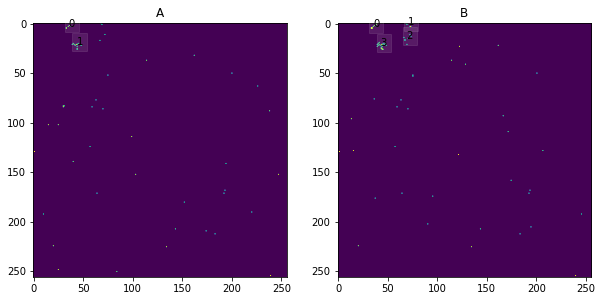

In [22]:


fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
cnames = ['A','B']
centroids, _ = measure_clusters(get_clusters(B, dbscan))
axis[0].imshow(B)
for centr_number, centroid in enumerate(centroids):
    axis[0].set_title(cnames[0])
    axis[0].text(x = centroid[1], y = centroid[0], s=str(centr_number), bbox=dict(color='white', alpha=0.1))
    
centroids, _ = measure_clusters(get_clusters(A, dbscan))
axis[1].imshow(A)
for centr_number, centroid in enumerate(centroids):
    axis[1].set_title(cnames[1])
    axis[1].text(x = centroid[1], y = centroid[0], s=str(centr_number), bbox=dict(color='white', alpha=0.1))

In [23]:
shape.shape

(2, 4)

Text(609.9818181818181, 0.5, 'A')

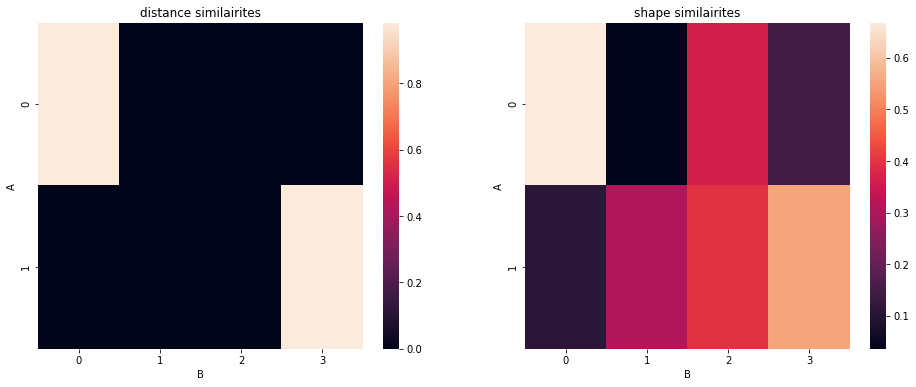

In [24]:
fig, axis = plt.subplots(1, 2, figsize=(16,6))
sns.heatmap(dist, ax = axis[0])
axis[0].set_title('distance similairites')
sns.heatmap(shape, ax = axis[1])
axis[1].set_title('shape similairites')
axis[0].set_xlabel('B')
axis[0].set_ylabel('A')
axis[1].set_xlabel('B')
axis[1].set_ylabel('A')


Text(51.0, 0.5, 'A')

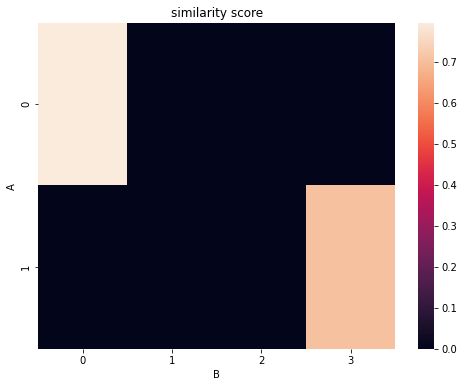

In [25]:
fig, axis = plt.subplots(1, 1, figsize=(8,6))
sns.heatmap(simmilarities, ax=axis)
axis.set_title('similarity score')
axis.set_xlabel('B')
axis.set_ylabel('A')

Text(51.0, 0.5, 'A')

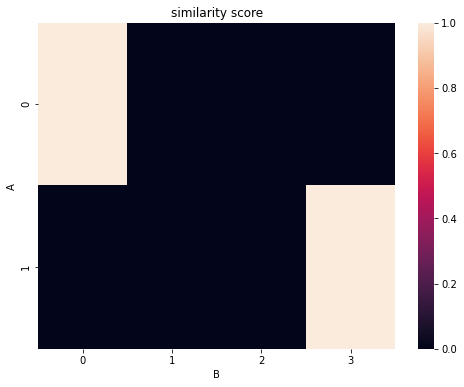

In [26]:
fig, axis = plt.subplots(1, 1, figsize=(8,6))
sns.heatmap(find_strong_max(simmilarities), ax=axis)
axis.set_title('similarity score')
axis.set_xlabel('B')
axis.set_ylabel('A')

In [27]:
def get_cluster_mapping(simmilarity_matrix):
    cluster_pairs =  {}
    for col_idx, column in enumerate(find_strong_max(simmilarity_matrix.T)):
        if np.max(column) == 1:
            cluster_pairs[col_idx] = np.argmax(column)
    return cluster_pairs

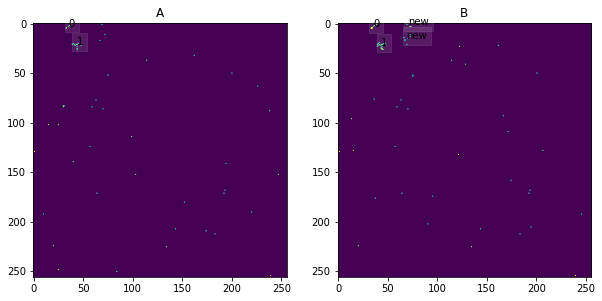

In [28]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

centroids, _ = measure_clusters(get_clusters(B, dbscan))
axis[0].imshow(B)
for centr_number, centroid in enumerate(centroids):
    axis[0].set_title(cnames[0])
    axis[0].text(x = centroid[1], y = centroid[0], s=str(centr_number), bbox=dict(color='white', alpha=0.1))
    
centroids, _ = measure_clusters(get_clusters(A, dbscan))
axis[1].imshow(A)
label_mapping = get_cluster_mapping(simmilarities)
for centr_number, centroid in enumerate(centroids):
    axis[1].set_title(cnames[1])
    if centr_number in label_mapping.keys():
        name = str(label_mapping[centr_number])
    else:
        name = 'new'
    axis[1].text(x = centroid[1], y = centroid[0], s=name, bbox=dict(color='white', alpha=0.1))

# Phase 1

### Novelty

In [29]:
def new_and_lost_clusters_between(curr_map, prev_map, dbscan):
    simmilarities, (dist, shape) = cluster_simmilarity(get_clusters(curr_map, dbscan),
                                                       get_clusters(prev_map, dbscan))
    if simmilarities is None:
        return 0, 0
    
    cluster_pairs_matrix = find_strong_max(simmilarities)
    
    new = np.where(np.sum(cluster_pairs_matrix, axis = 0) == 0)[0].shape[0]
    lost = np.where(np.sum(cluster_pairs_matrix, axis = 1) == 0)[0].shape[0]
    return new, lost


def novelty_measures(curr_map, prev_map, dbscan):
    new_points_count = np.sum(np.clip(curr_map-prev_map, a_min=0, a_max=1))
    lost_points_count = np.sum(np.clip(prev_map-curr_map, a_min=0, a_max=1))
    
    number_of_new_clusters, number_of_lost_clusters = new_and_lost_clusters_between(curr_map, prev_map, dbscan)
    
    curr_clusters = get_clusters(curr_map, dbscan)
    curr_clusters = curr_clusters[np.where(curr_clusters[:,0] != -1)]
    prev_clusters = get_clusters(prev_map, dbscan)
    prev_clusters = prev_clusters[np.where(prev_clusters[:,0] != -1)]
    points_in_clusters_shared = np.vstack((curr_clusters, prev_clusters)).shape[0] \
                            - np.unique(np.vstack((curr_clusters, prev_clusters)), axis=0).shape[0]
    new_points_in_clusters_count = curr_clusters.shape[0] - points_in_clusters_shared
    lost_points_in_clusters_count = prev_clusters.shape[0] - points_in_clusters_shared
    
    return (new_points_count,
            lost_points_count,
            number_of_new_clusters,
            number_of_lost_clusters,
            new_points_in_clusters_count,
            lost_points_in_clusters_count)
    

In [30]:
novelty_measures(A, B, dbscan)

(36.0, 19.0, 0, 2, 34, 11)

### Outlierness

In [31]:
from sklearn.neighbors import NearestNeighbors

In [32]:
def local_density_imbalance(curr_map, n_neighbors):
    points = np.array(np.where(curr_map != 0)).T
    near_neigh = NearestNeighbors(n_neighbors=1+n_neighbors)
    near_neigh.fit(points)
    

    std_of_avg_knn_distance = np.std(np.mean(near_neigh.kneighbors(points)[0][:,1:], axis=1))
    return std_of_avg_knn_distance

def directional_density_imbalance(curr_map, n_neighbors):
    points = np.array(np.where(curr_map != 0)).T
    near_neigh = NearestNeighbors(n_neighbors=1+n_neighbors)
    near_neigh.fit(points)
    densities = np.sum(near_neigh.kneighbors(points)[0][:,1:], axis=1)
    lr = LinearRegression()
    lr.fit(X=points, y=densities)
    return lr.coef_

        
def outlierness_measures(curr_map, dbscan, n_neighbors=5):
    
    curr_clusters = get_clusters(curr_map, dbscan)
    curr_clusters = curr_clusters[np.where(curr_clusters[:,0] != -1)]
    number_of_clusters = np.unique(curr_clusters[:,0]).shape[0]
    total_points = np.where(curr_map != 0)[0].shape[0]
    points_in_clusters = curr_clusters.shape[0]
    total_points_normalized = total_points
    
    directional_imbalance_coef =  directional_density_imbalance(curr_map, n_neighbors)
    local_imbalance_coef = local_density_imbalance(curr_map, n_neighbors)
    
    x_directional_imbalance_coef, y_directional_imbalance_coef = directional_imbalance_coef
    return (number_of_clusters,
            points_in_clusters,
            total_points_normalized,
            x_directional_imbalance_coef,
            y_directional_imbalance_coef,
            local_imbalance_coef)
    

In [33]:
outlierness_measures(A, dbscan)

(4, 40, 73, 1.0562329286387315, 0.40944234504977556, 21.629547838393904)

In [34]:
num_trees = 30
tree_size = 6
shingle_size = 2

curr_map = np.zeros((256,256))
codisp_hist = []

forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)

index = 0

lines = []
blobs = []

In [35]:
# Use the "shingle" generator to create rolling window
rgen = randmap_generator(gaussian_blob_prob=0.03, line_prob=0.02, n=300, starting_map=curr_map)
# Create a dict to store anomaly score of each point
rgen_shingled = rrcf.shingle(rgen, size=shingle_size)
# For each shingle...
start = True
for rmap in rgen_shingled:
    if start is True:
        start = False
        pass
    else:
        rmap_measures = novelty_measures(curr_map = rmap[1], prev_map=rmap[0], dbscan=dbscan)
        codisps = []
        for tree in forest:
            new_index = np.random.randint(tree_size)
            if len(tree.leaves) > tree_size:
                tree.forget_point(new_index)
                tree.insert_point(rmap_measures, index=new_index)
                codisps.append(tree.codisp(new_index))
            else:
                tree.insert_point(rmap_measures, index=index)
                codisps.append(tree.codisp(index))
        new_codisp = np.mean(codisps)
#         print(new_codisp)
        codisp_hist.append(new_codisp)
        index += 1
    

/usr/lib/python3/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid valu

/usr/lib/python3/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


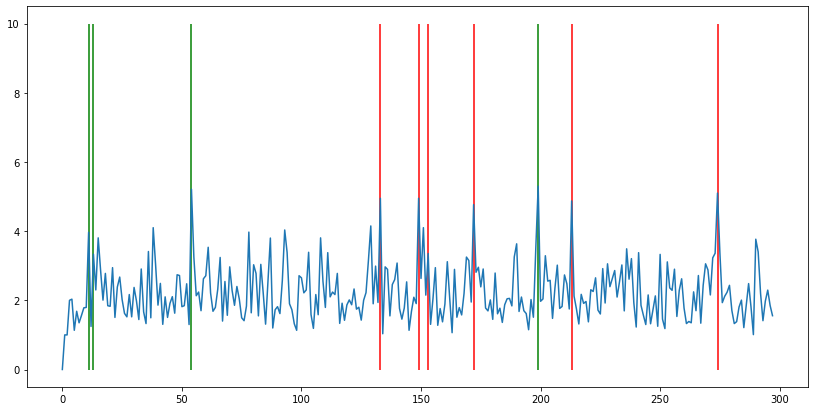

In [36]:
fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.plot(codisp_hist)
ax1.vlines(blobs, ymin=0, ymax=10, colors='red')
ax1.vlines(lines, ymin=0, ymax=10, colors='green')